<a href="https://colab.research.google.com/github/mattiasthalen/RepOne-Strength/blob/main/Pyro_RepOne_Strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RepOne Strength

## Setup Environment


In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install --upgrade -q jax jaxlib
!pip install ipython-autotime

# Need to restart the kernel after installation
import os
os.kill(os.getpid(), 9)

In [ ]:
%load_ext autotime

time: 3.61 ms (started: 2021-06-23 19:03:40 +00:00)


In [ ]:
import requests
import os
import numpyro
import jax
import sklearn.preprocessing

import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from collections import OrderedDict
from google.colab import drive
from requests import get
from urllib.parse import unquote

time: 13.6 ms (started: 2021-06-23 19:20:45 +00:00)


In [ ]:
# Colab runtime set to TPU accel
if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
jax.config.FLAGS.jax_xla_backend = "tpu_driver"
jax.config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

platform = jax.lib.xla_bridge.get_backend().platform
backend_target = jax.config.FLAGS.jax_backend_target
print(f'{platform}: {backend_target}')

tpu: grpc://10.97.50.18:8470
time: 21.9 s (started: 2021-06-23 19:03:48 +00:00)


In [48]:
base_path = '/content/drive'
drive.mount(base_path)

notebook_name = unquote(get('http://172.28.0.2:9000/api/sessions').json()[0]['name'])
notebook_path = f'{base_path}/MyDrive/Colab Notebooks/{notebook_name}'
hist_xr_path = f'{notebook_path}/hist_xr.nc'
csv_export_path = f'{notebook_path}/RepOne_Data_Export.csv'

new_data_available = os.path.getmtime(csv_export_path) > os.path.getmtime(hist_xr_path)

Mounted at /content/drive


True

time: 1.76 s (started: 2021-06-23 21:06:24 +00:00)


## Load Data

In [49]:
data = xr.open_dataset(hist_xr_path)
data

<xarray.Dataset>
Dimensions:                          (aggregation: 9, coefficient: 3, dim_0: 80, exercise: 4, rep: 7, sample: 2000, set: 22, workout_start_time: 80)
Coordinates: (12/14)
  * workout_start_time               (workout_start_time) datetime64[ns] 2020...
  * exercise                         (exercise) object 'bench press' ... 'squat'
  * set                              (set) int64 0 1 2 3 4 5 ... 17 18 19 20 21
  * rep                              (rep) int64 0 1 2 3 4 5 6
    metric                           (exercise, workout_start_time, set, rep) object ...
    tags                             (exercise, workout_start_time, set, rep) object ...
    ...                               ...
    training_cycle                   (workout_start_time) float64 ...
    cycle_type                       (dim_0) object ...
  * dim_0                            (dim_0) datetime64[ns] 2020-12-29 ... 20...
  * coefficient                      (coefficient) object 'alpha' ... 'beta1'
  * sample                           (sample) int64 0 1 2 3 ... 1997 1998 1999
    max_weight_pr_flag               (exercise, workout_start_time) float64 ...
Data variables: (12/24)
    weight                           (exercise, workout_start_time, set) float64 ...
    set_rpe                          (exercise, workout_start_time, set, rep) float64 ...
    rest_time                        (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                     (exercise, workout_start_time, set, rep) float64 ...
    range_of_motion                  (exercise, workout_start_time, set, rep) float64 ...
    peak_velocity                    (exercise, workout_start_time, set, rep) float64 ...
    ...                               ...
    session_relative_volume          (exercise, workout_start_time, sample) float64 ...
    rep_exertion                     (exercise, workout_start_time, sample, set, rep) float64 ...
    rep_force                        (exercise, workout_start_time, set, rep) float64 ...
    rep_energy                       (exercise, workout_start_time, set, rep) float64 ...
    session_exertion_load            (exercise, workout_start_time, sample) float64 ...
    session_exertion_load_summary    (exercise, workout_start_time, aggregation) float64 ...

time: 806 ms (started: 2021-06-23 21:07:44 +00:00)


In [ ]:
regr_data = (data[['weight', 'set_velocities']].sel({'aggregation': 'max'}, drop = True)
                                               .where(data.coords['set_type'] != 'Back Off')
                                               .drop_vars(['set_type', 'training_cycle', 'max_weight_pr_flag'])
                                               .to_dataframe()
                                               .dropna()
                                               .reset_index()
                                               .sort_values(by = ['exercise', 'workout_start_time', 'set'])
                                               .rename(columns = {'set_velocities': 'velocity'}))

regr_data['exercise_id'], exercises = pd.factorize(regr_data['exercise'])
regr_data['session_id'], workout_start_times = pd.factorize(regr_data['workout_start_time'])
regr_data['observation'] = np.arange(len(regr_data))
regr_data.set_index('observation', inplace = True)

regr_data

,exercise,set,workout_start_time,weight,velocity,exercise_id,session_id
observation,,,,,,,
0,bench press,0,2021-01-05 10:56:06,20.0,0.77,0,0
1,bench press,1,2021-01-05 10:56:06,30.0,0.77,0,0
2,bench press,2,2021-01-05 10:56:06,40.0,0.59,0,0
3,bench press,3,2021-01-05 10:56:06,50.0,0.46,0,0
4,bench press,4,2021-01-05 10:56:06,60.0,0.44,0,0
...,...,...,...,...,...,...,...
1202,squat,6,2021-06-15 11:52:35,120.0,0.49,3,68
1203,squat,7,2021-06-15 11:52:35,130.0,0.41,3,68
1204,squat,8,2021-06-15 11:52:35,135.0,0.36,3,68


time: 132 ms (started: 2021-06-23 19:21:42 +00:00)


In [ ]:
data_dict = OrderedDict({'x': regr_data['weight'].values,
                         'y': regr_data['velocity'].values,
                         'level1': regr_data['exercise'].values,
                         'level2': regr_data['workout_start_time'].values})
data_dict

OrderedDict([('x', array([ 20. ,  30. ,  40. , ..., 135. , 140. , 142.5])),
             ('y', array([0.77, 0.77, 0.59, ..., 0.36, 0.32, 0.25])),
             ('level1',
              array(['bench press', 'bench press', 'bench press', ..., 'squat', 'squat',
                     'squat'], dtype=object)),
             ('level2',
              array(['2021-01-05T10:56:06.000000000', '2021-01-05T10:56:06.000000000',
                     '2021-01-05T10:56:06.000000000', ...,
                     '2021-06-15T11:52:35.000000000', '2021-06-15T11:52:35.000000000',
                     '2021-06-15T11:52:35.000000000'], dtype='datetime64[ns]'))])

time: 15.3 ms (started: 2021-06-23 19:55:48 +00:00)


## Model Data

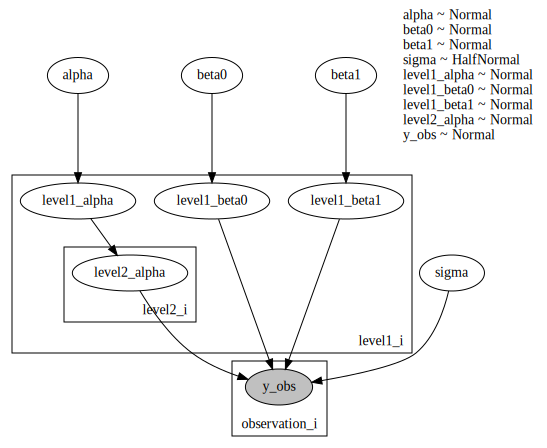

time: 2.95 s (started: 2021-06-23 19:55:55 +00:00)


In [ ]:
def quadratic_model(x,
                    y = None,
                    level1 = None,
                    level2 = None,
                    inverse = False,
                    standardize = True):
    '''
    Bayesian model to estimate the parameters used in the quadratic regression `y = alpha + beta0*x + beta1*x^2`.
    Up to two additional levels are supported to make a hierarchical model.

    Parameters
    ----------
    x : list of float
        The independent variable.
    y : list of float, optional
        Dependent variable.
    level1 : list, optional
        Optional list for additional level in i regression.
    level2 : list, optional
        Optional list for additional level in i regression.
    inverse : bool, default False
        Flip the independent & dependent variable.
    standardize : bool, default True
        Standardize variables using `sklearn.preprocessing.StandardScaler()`.
    '''

    x_obs, y_obs = [x, y] if not inverse else [y, x]

    # Hyperparameters
    alpha = numpyro.sample('alpha', numpyro.distributions.Normal(0, 1))
    beta0 = numpyro.sample('beta0', numpyro.distributions.Normal(0, 1))
    beta1 = numpyro.sample('beta1', numpyro.distributions.Normal(0, 1))
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfNormal(1))
    
    # Level 1 Parameters
    if level1 is not None:
        level1_id, level1_cat = pd.factorize(level1)
        n_level1_ids = len(level1_cat)

        with numpyro.plate('level1_i', n_level1_ids, dim = -1):
            level1_alpha = numpyro.sample('level1_alpha', numpyro.distributions.Normal(alpha, 1))
            level1_beta0 = numpyro.sample('level1_beta0', numpyro.distributions.Normal(beta0, 1))
            level1_beta1 = numpyro.sample('level1_beta1', numpyro.distributions.Normal(beta1, 1))

            # Level 2 Parameters
            if level2 is not None:
                level2_id, level2_cat = pd.factorize(level2)
                n_level2_ids = len(level2_cat)

                with numpyro.plate('level2_i', n_level2_ids, dim = -2):
                    level2_alpha = numpyro.sample('level2_alpha', numpyro.distributions.Normal(level1_alpha, 1))

    # Standardize variables
    if standardize:
        xy_scaler = sklearn.preprocessing.StandardScaler()
        xy = np.array(list(zip(x_obs, y_obs)))
        xy_scaled = xy_scaler.fit_transform(xy)
        x_obs, y_obs = np.array(list(zip(*xy_scaled)))
        x_mean, y_mean = xy_scaler.mean_
        x_sd, y_sd = xy_scaler.scale_
    
        inverse_alpha = lambda: y_sd*(alpha - beta0*x_mean/x_sd + beta1*x_mean**2/x_sd**2) + y_mean
        inverse_beta0 = lambda: beta0*y_sd/x_sd - 2*beta1*x_mean*y_sd/x_sd**2
        inverse_beta1 = lambda: beta1*y_sd/x_sd**2

        numpyro.deterministic('alpha_unscaled', inverse_alpha())
        numpyro.deterministic('beta0_unscaled', inverse_beta0())
        numpyro.deterministic('beta1_unscaled', inverse_beta1())

    # Update parameter assignments
    if level1 is not None:
        alpha = level1_alpha[level1_id]
        beta0 = level1_beta0[level1_id]
        beta1 = level1_beta1[level1_id]

        if standardize:
            numpyro.deterministic('level1_alpha_unscaled', inverse_alpha())
            numpyro.deterministic('level1_beta0_unscaled', inverse_beta0())
            numpyro.deterministic('level1_beta1_unscaled', inverse_beta1())
    
    if (level1 is not None) & (level2 is not None):
        alpha = level2_alpha[level2_id, level1_id]

        if standardize:   
            numpyro.deterministic('level2_alpha_unscaled', inverse_alpha())

    # Likelihood
    mu = alpha + beta0*x_obs + beta1*x_obs**2

    with numpyro.plate('observation_i', len(x_obs)):
        numpyro.sample('y_obs', numpyro.distributions.Normal(mu, sigma), obs = y_obs)

numpyro.render_model(quadratic_model, model_kwargs = data_dict, render_distributions = True)

In [ ]:
def run_inference(model_fn,
                  target_accept_prob = 0.8,
                  num_samples = 2000,
                  num_warmup = 2000,
                  num_chains = 1,
                  num_prior_samples = 500,
                  **kwargs):
    
    rng_key0 = jax.random.PRNGKey(0)
    rng_key1 = jax.random.PRNGKey(1)
    rng_key2 = jax.random.PRNGKey(2)

    nuts_kernel = numpyro.infer.NUTS(model_fn,
                                     target_accept_prob = target_accept_prob)
    mcmc = numpyro.infer.MCMC(nuts_kernel,
                              num_samples = num_samples,
                              num_warmup = num_warmup,
                              num_chains = num_chains)

    mcmc.run(rng_key0, **kwargs)

    prior = numpyro.infer.Predictive(model_fn, num_samples = num_prior_samples)
    prior_samples = prior(rng_key1, **kwargs)

    posterior_predictive = numpyro.infer.Predictive(model_fn, posterior_samples = mcmc.get_samples())
    posterior_predictive_samples = posterior_predictive(rng_key2, **kwargs)

    '''
    coords = {'observation': np.arange(len(kwargs['x']))}
    dims = {'observed': ['observation']}

    if level1 is not None:
        level1_title, level1_vals = list(level1.items())[0]
        level1_id, level1_vals = pd.factorize(level1_vals)
        kwargs['level1_id'] = level1_id
        coords[level1_title] = level1_vals
        dims['level1_alpha'] = [level1_title]
        dims['level1_beta0'] = [level1_title]
        dims['level1_beta1'] = [level1_title]

        if level2 is not None:
            level2_title, level2_vals = list(level2.items())[0]
            level2_id, level2_vals = pd.factorize(level2_vals)
            kwargs['level2_id'] = level2_id
            coords[level2_title] = level2_vals
            dims['level1_alpha_sigma'] = [level1_title]
            dims['level2_alpha'] = [level2_title, level1_title]
    '''

    inference_data = az.from_numpyro(mcmc,
                                     prior = prior_samples,
                                     posterior_predictive = posterior_predictive_samples)

    return inference_data

time: 30.9 ms (started: 2021-06-23 19:21:56 +00:00)


### Model velocity from weight

In [ ]:
velocity_inference_mcmc = run_inference(model_fn = quadratic_model,
                                        target_accept_prob = 0.98,
                                        num_chains = 4,
                                        **data_dict)

velocity_inference_mcmc.to_netcdf('velocity_inference_mcmc.nc')
velocity_inference_mcmc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

time: 7min 40s (started: 2021-06-23 19:56:08 +00:00)


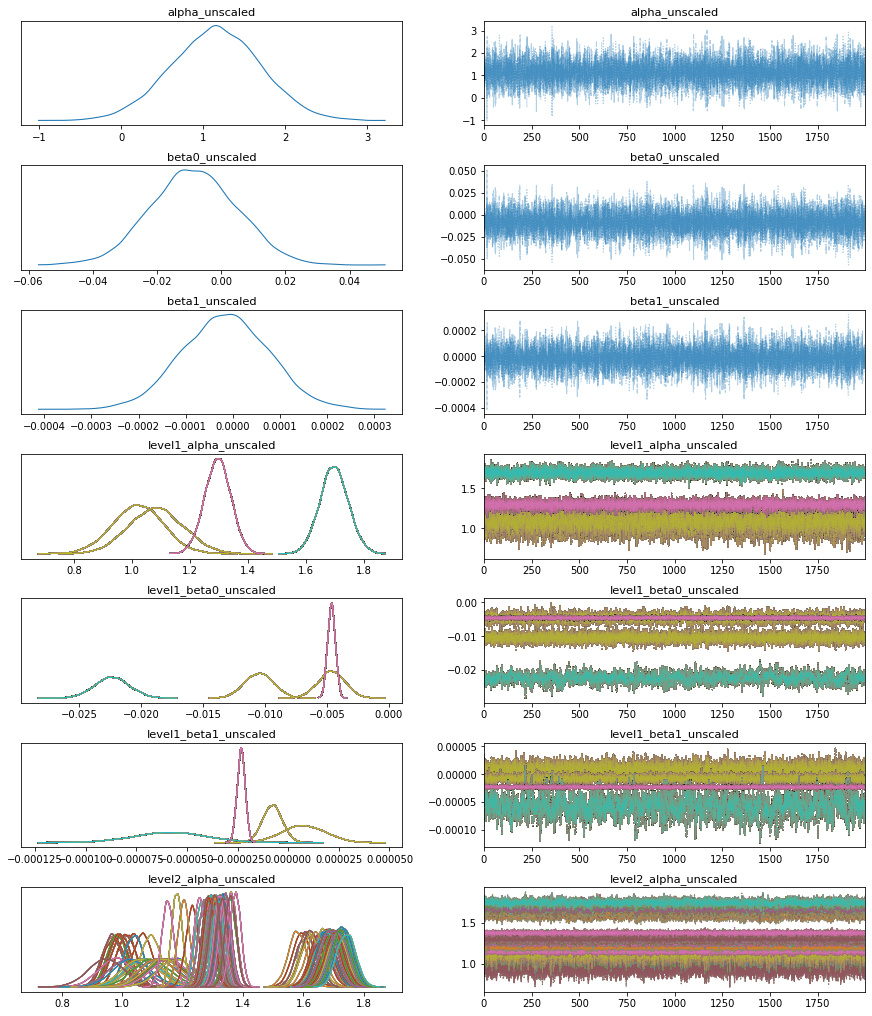

time: 7min 58s (started: 2021-06-23 20:05:32 +00:00)


In [ ]:
_ = az.plot_trace(velocity_inference_mcmc,
                  compact = True,
                  combined = True,
                  var_names = 'unscaled',
                  filter_vars = 'like')

## Model Using SVI

In [ ]:
quadratic_guide = numpyro.infer.autoguide.AutoMultivariateNormal(quadratic_model, init_loc_fn = numpyro.infer.init_to_median)
svi = numpyro.infer.SVI(model = quadratic_model,
                        guide = quadratic_guide,
                        optim = numpyro.optim.Adam({'lr': 0.01}),
                        loss = numpyro.infer.Trace_ELBO())

svi_result = svi.run(rng_key = jax.random.PRNGKey(3),
                     num_steps = 2000,
                     **load_dict)

  0%|          | 0/2000 [00:00<?, ?it/s]


TypeError: ignored